# Proyecto de Regresión Lineal

In [35]:
# Importaciones necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

## Paso 1: Cargar el conjunto de datos

In [3]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Paso 2: Realizar un EDA completo

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.duplicated().sum() # Comprobar la presencia de filas duplicadas

1

In [6]:
df.drop_duplicates(inplace=True) # Eliminar filas duplicadas
df.shape

(1337, 7)

In [7]:
df.isnull().sum() # Valores nulos 

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
df.nunique() # Valores unicos por columna

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

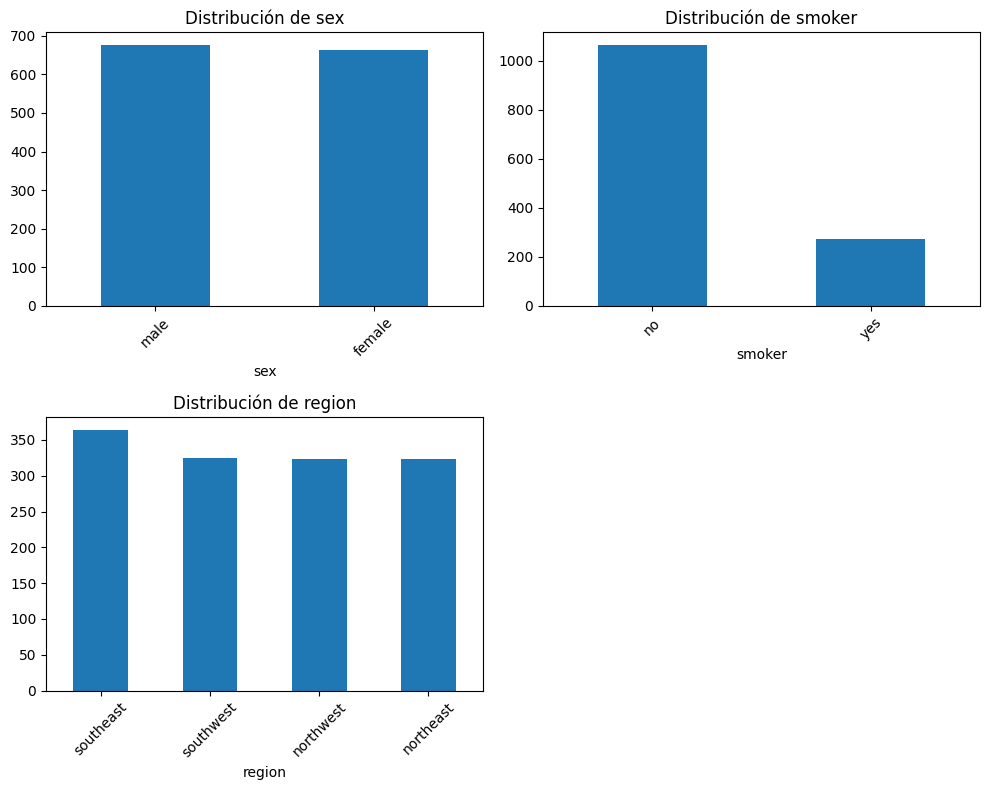

In [9]:
# Seleccionamos columnas categóricas
categorical_cols = df.select_dtypes(include='object').columns

# Configuramos número de filas y columnas para subplots
n_cols = 2
n_rows = 2

# Creamos la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Generamos cada gráfica en su subplot
for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminamos ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
# Relacion de las variables categoricas con la variable objetivo
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan  # No tiene sentido calcularlo si solo hay una fila o columna

    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Aplicación a todas las combinaciones de variables categóricas
categorical = ['sex', 'smoker', 'region']  # tus variables categóricas

for col in categorical:
    print(f"Cramér's V entre '{col}' y 'charges': {cramers_v(df[col], pd.qcut(df['charges'], q=4))}")


Cramér's V entre 'sex' y 'charges': 0.0736990090060492
Cramér's V entre 'smoker' y 'charges': 0.7953915761154823
Cramér's V entre 'region' y 'charges': 0.05527552343334852


**Observacion:** Se puede notar que las variables sex y region tienen muy baja relacion, sobre todo region, vamos a eliminar esa ultima.

In [11]:
df.drop('region', axis=1, inplace=True)

### Codificacion de variables categoricas

In [12]:
# Codificación binaria directa
df["sex"] = df["sex"].map({"female": 0, "male": 1})
df["smoker"] = df["smoker"].map({"no": 0, "yes": 1})

In [13]:
# Validamos que no queden columnas tipo objet
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
charges     float64
dtype: object

### Distribución de variables numericas

In [14]:
df.describe().T # Estadistica descrptiva para las columnas numericas

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
sex,1337.0,0.504862,0.500163,0.0000,0.000,1.0000,1.00000,1.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
smoker,1337.0,0.204936,0.403806,0.0000,0.000,0.0000,0.00000,1.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


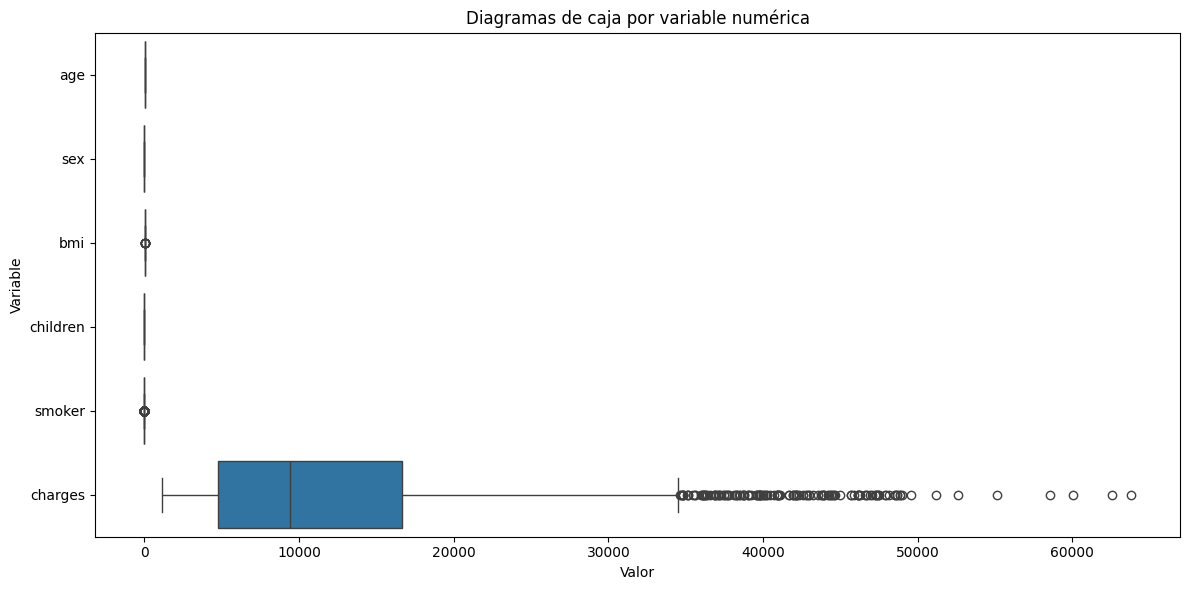

In [15]:
# Variables numéricas 
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Convertir a formato largo (tidy) es decir de un dataframe a solo dos columnas
df_long = df[num_cols].melt(var_name='variable', value_name='valor')

# Boxplot horizontal con seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long, y='variable', x='valor', orient='h')
plt.title('Diagramas de caja por variable numérica')
plt.xlabel('Valor')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

### Partición de datos

In [16]:
X = df.drop(['charges'],axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(1069, 5)

### Observación de influyentes

In [22]:
# Ajustar el modelo
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

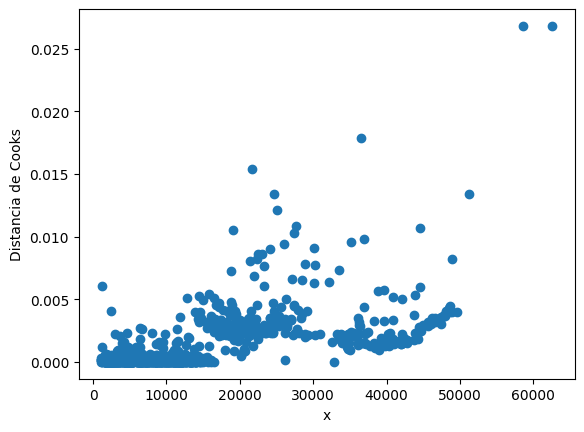

In [23]:
plt.scatter(y_train, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Distancia de Cooks')
plt.show()

**Observaciones:**
- No hay muchas observaciones influyentes en el dataset
- Los datos están bastante estables, y no hay outliers que pudiera afectar los coeficientes de regresión logística, notando que los valores estan muy cercanos a 0. 

### Selección de características

In [24]:
# Añadimos constante para el intercepto
X_train_const = sm.add_constant(X_train)

# Entrenamos el modelo OLS de regresión lineal
model = sm.OLS(y_train, X_train_const).fit()

# Extraemos parámetros excepto el intercepto
coefs = model.params.drop('const')

# Creamos DataFrame con importancia (valor absoluto multiplicado por 100 para escala)
dict_data = {
    'Feature': coefs.index,
    'Importancia': np.abs(coefs.values) * 100
}
df_imp = pd.DataFrame(dict_data)

# Ordenamos por importancia descendente
df_imp.sort_values(by='Importancia', ascending=False, inplace=True)

df_imp

,Feature,Importancia
4,smoker,2.305137e+06
3,children,5.379634e+04
2,bmi,3.055965e+04
0,age,2.490952e+04
1,sex,8.502704e+03


**Observacion:** Se identifica que las variables mas importantes son si es fumador y si tiene hijos, las menos importantes, la edad y sexo en ese orden.

In [26]:
# Calcular VIF para cada variable 
vif = pd.Series(
    [variance_inflation_factor(X_train_const.values, i) 
     for i in range(1, X_train_const.shape[1])],  # Empieza en 1 para saltar la constante
    index=X_train.columns
)

print(vif)

age         1.021012
sex         1.009939
bmi         1.017674
children    1.003694
smoker      1.009191
dtype: float64


**Observacion:** Todas las variables tienen Valores de VIF cerca de 1, por lo que no hay correlación lineal entre 
ellas.  
Ya que no es necesario escalar las variables vamos a continuar con la construccion del modelo.

## Paso 3: Construir un modelo de regresión lineal

In [46]:
model = LinearRegression() # Creamos el modelo
model.fit(X_train, y_train) # Entrenamos el modelo con los datos de entrenamiento

#  Hacemos predicciones sobre train y test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluamos el desempeño en train y test
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train Lineal MSE: {mse_train:.2f}")
print(f"Train Lineal R2: {r2_train:.2f}")
print(f"Test Lineal MSE: {mse_test:.2f}")
print(f"Test Lineal R2: {r2_test:.2f}")

Train Lineal MSE: 37072507.17
Train Lineal R2: 0.73
Test Lineal MSE: 35901914.11
Test Lineal R2: 0.80


**Observaciones:** 
- Basado en el R cuadrado el modelo explica bastante bien los datos de entrenamiento y asombrosamente mucho mejor los de test, lo cual nos da tambien idea de que no esta sobreajustando.
- El error cuadrático medio es alto, pero tambien se debe tener en cuenta que esta en los terminos de la variable objetivo la cual esta en decenas y cientos de miles, por lo que tambien es un buen resultado.

In [30]:
# Validamos los coeficientes del modelo
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)

    Feature   Coefficient
4    smoker  23051.368124
3  children    537.963367
2       bmi    305.596495
0       age    249.095218
1       sex    -85.027041


## Paso 4: Optimiza el modelo anterior

In [32]:
# Vamos a iniciar estandarizando las variables
scaler = StandardScaler() # Se crea el escalador
X_train_scaled = scaler.fit_transform(X_train) # Se aplica a train
X_test_scaled = scaler.transform(X_test) # Se aplica a test

In [42]:
# Modelo mejorado con Rigde
ridge = Ridge() 

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Probamos varios valores para alpha

grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train_scaled, y_train)

print("Mejor alpha para Ridge:", grid_ridge.best_params_)
print("Mejor score CV para Ridge:", grid_ridge.best_score_)

# Evaluar en test
y_pred_ridge = grid_ridge.predict(X_test_scaled)
y_train_pred_ridge = grid_ridge.predict(X_train_scaled)

Mejor alpha para Ridge: {'alpha': 10}
Mejor score CV para Ridge: 0.7257193383809117


In [43]:
# Modelo mejorado con Lasso
lasso = Lasso(max_iter=10000)  # max_iter alto para el mejor caso

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}  # Valores para alpha

grid_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train_scaled, y_train)

print("Mejor alpha para Lasso:", grid_lasso.best_params_)
print("Mejor score CV para Lasso:", grid_lasso.best_score_)

# Evaluar en test
y_pred_lasso = grid_lasso.predict(X_test_scaled)
y_train_pred_lasso = grid_lasso.predict(X_train_scaled)

Mejor alpha para Lasso: {'alpha': 1}
Mejor score CV para Lasso: 0.7256227000836875


In [48]:
# Metricas de regresion lineal
print(f"Test Lineal R2: {r2_test:.2f}")
print(f"Test Lineal MSE: {mse_test:.2f}")
print(f"Train Lineal R2: {r2_train:.2f}")
print(f"Train Lineal MSE: {mse_train:.2f}")

# Métricas para Ridge
print("Ridge Test R2:", r2_score(y_test, y_pred_ridge))
print("Ridge Test MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Ridge Train R2:", r2_score(y_train, y_train_pred_ridge))
print("Ridge Train MSE:", mean_squared_error(y_train, y_train_pred_ridge))

# Métricas en train para Lasso
print("Lasso Test R2:", r2_score(y_test, y_pred_lasso))
print("Lasso Test MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Lasso Train R2:", r2_score(y_train, y_train_pred_lasso))
print("Lasso Train MSE:", mean_squared_error(y_train, y_train_pred_lasso))

Test Lineal R2: 0.80
Test Lineal MSE: 35901914.11
Train Lineal R2: 0.73
Train Lineal MSE: 37072507.17
Ridge Test R2: 0.8027836804244679
Ridge Test MSE: 36239694.6498714
Ridge Train R2: 0.7291644772119317
Ridge Train MSE: 37081356.25928166
Lasso Test R2: 0.8045947642716651
Lasso Test MSE: 35906897.01046203
Lasso Train R2: 0.729229073082048
Lasso Train MSE: 37072512.13703356


**Conclusion de las metricas:**  
- R cuadrado esta cerca de 0.73 en train y 0.80 en test para todos los modelos, lo cual es bastante bueno pero no se ha obtenido mejora con los nuevos modelos.

- MSE son muy similares entre los modelos, con valores de error alrededor de 35000 para test y 37000 para train, lo cual indica que el error promedio se encuentra en ese rango.  

- Pareciera no haber una mejora significativa, lo que quiere decir que el modelo de regresion lineal es bastante bueno para predecir este comportamiento de seguros y no es necesario otros modelos de regresion mas complejos, sim enbargo podria probarse con modelos de arboles u otros modelos para tener mejores resultados.

In [52]:
# Cieficientes de regresion lineal
print("Coeficientes Regresion lineal:")
print(coef_df)

# Coeficientes de Ridge
coef_ridge = grid_ridge.best_estimator_.coef_
print("\nCoeficientes Ridge:")
for feature, coef in zip(X_train.columns, coef_ridge):
    print(f"{feature}: {coef}")

# Coeficientes de Lasso
coef_lasso = grid_lasso.best_estimator_.coef_
print("\nCoeficientes Lasso:")
for feature, coef in zip(X_train.columns, coef_lasso):
    print(f"{feature}: {coef}")

Coeficientes Regresion lineal:
    Feature   Coefficient
4    smoker  23051.368124
3  children    537.963367
2       bmi    305.596495
0       age    249.095218
1       sex    -85.027041

Coeficientes Ridge:
age: 3451.848171509776
sex: -35.18340758838798
bmi: 1833.43329407062
children: 639.9262871454576
smoker: 9136.13460471038

Coeficientes Lasso:
age: 3484.5117240618147
sex: -41.386196697182406
bmi: 1847.5926004142102
children: 641.486994281425
smoker: 9222.651398968812


**Conclusiones adicionales:**
- Los coeficientes de lasso y Rigde distan un poco del modelo de regresion lineal, ya que posiblemente penalizan la variable mas importante (smoker), sin emabrgo tienen un desempeño similar.
- A pesar de los cambios magnitud entre ellos, todos los modelos concuerdan en la relacion de las variables independientes con la variable objetivo, por ejemplo smoker es la mas importante y sex es inversamente proporcional.